In [ ]:
# Competição Kaggle ML Olympiad - QUALITY EDUCATION
# ML Olympiad – Previsão das notas da prova do ENEM

# Participantes: Nathália Santiago | Dandara | Priscila Santos - Fevereiro 2022

#LINK: https://www.kaggle.com/c/qualityeducation/overview

In [ ]:
## ANÁLISE EXPLORATÓRIA DOS DADOS ##

In [4]:
#Importando Bibliotecas
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

DEBUG = True

In [5]:
#Importando os data frames train e test
#Ler o .csv e depois transformar em parquet para economizar memória
df_train = pd.read_csv('/content/train.csv', sep="," , encoding="UTF8" )
df_train.to_parquet('/content/train.parquet', engine='pyarrow', compression='gzip')

In [6]:
df_test = pd.read_csv('/content/test.csv', sep="," , encoding="UTF8" )
df_test.to_parquet('/content/test.parquet', engine='pyarrow', compression='gzip')

In [ ]:
pd.read_parquet('/content/train.parquet', engine='pyarrow')

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,...,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31.0,F,0.0,1.0,1.0,3200607.0,Aracruz,32.0,ES,1.0,10.0,1.0,1.0,0.0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1100023.0,Ariquemes,11.0,RO,1.0,1.0,1.0,1.0,426.5,487.4,530.9,415.3,1.0,1.0,680.0,B,A,A,A,2.0,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23.0,F,1.0,3.0,1.0,3106200.0,Belo Horizonte,31.0,MG,1.0,3.0,1.0,NaN,0.0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3106200.0,Belo Horizonte,31.0,MG,1.0,1.0,1.0,1.0,463.0,452.3,456.6,407.2,0.0,1.0,520.0,B,C,D,B,2.0,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17.0,M,0.0,3.0,1.0,3106200.0,Belo Horizonte,31.0,MG,2.0,0.0,2.0,1.0,0.0,31075167.0,3139409.0,Manhuaçu,31.0,MG,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3139409.0,Manhuaçu,31.0,MG,1.0,1.0,1.0,1.0,381.7,474.4,530.6,622.8,0.0,1.0,600.0,E,B,C,D,3.0,F,A,B,C,B,A,B,A,B,A,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,2506301,Guarabira,25,PB,16.0,M,1.0,1.0,1.0,2506301.0,Guarabira,25.0,PB,3.0,0.0,1.0,NaN,1.0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2506301.0,Guarabira,25.0,PB,1.0,1.0,1.0,1.0,426.7,343.9,444.2,507.0,1.0,1.0,660.0,C,E,B,B,4.0,B,A,B,D,A,A,B,B,A,A,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,2304400,Fortaleza,23,CE,19.0,M,1.0,1.0,1.0,2304400.0,Fortaleza,23.0,CE,1.0,1.0,1.0,NaN,0.0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2304400.0,Fortaleza,23.0,CE,1.0,1.0,1.0,1.0,623.7,609.1,637.1,805.3,0.0,1.0,840.0,G,E,E,B,2.0,L,D,E,E,B,A,B,A,B,A,B,A,A,E,B,B,C,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551605,68ed695f-3fdb-4d82-8254-35ecc204246c,1506807,Santarém,15,PA,23.0,F,1.0,3.0,1.0,1506807.0,Santarém,15.0,PA,1.0,1.0,1.0,NaN,0.0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1506807.0,Santarém,15.0,PA,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,B,C,B,B,6.0,B,A,B,D,A,A,A,A,B,A,A,A,A,B,A,A,C,A,A,A
551606,1bb95931-1454-4c27-8885-5f9f528f50a4,2800308,Aracaju,28,SE,18.0,F,1.0,3.0,1.0,2800308.0,Aracaju,28.0,SE,2.0,0.0,2.0,1.0,0.0,28018940.0,2800308.0,Aracaju,28.0,SE,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2800308.0,Aracaju,28.0,SE,1.0,1.0,1.0,1.0,369.6,439.2,518.3,420.5,1.0,1.0,640.0,B,B,B,B,10.0,C,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A
551607,28992f1f-309f-4250-a027-d8e27f509abf,5208806,Goianira,52,GO,52.0,M,3.0,3.0,1.0,3131604.0,Iraí de Minas,31.0,MG,1.0,1.0,1.0,NaN,0.0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0.0,

In [7]:
pd.read_parquet('/content/test.parquet', engine='pyarrow')

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,5d5b362b-7388-4ac6-81b3-23573e4e2d3a,2305506,Iguatu,23,CE,22.0,F,1,3,1,...,A,A,A,B,B,A,B,A,B,B
1,52356efd-3239-4cd2-a444-416625dfc560,3548500,Santos,35,SP,19.0,F,1,1,1,...,B,A,A,B,A,B,E,B,B,B
2,1ba42e9a-dd61-4405-9b08-79b728ad23c9,3552106,Socorro,35,SP,16.0,F,1,1,1,...,B,A,B,C,A,A,E,A,B,B
3,16fa0f84-a88f-43e6-bcbb-8d5ea41e5f03,3541000,Praia Grande,35,SP,22.0,M,1,1,1,...,B,A,A,C,A,B,C,B,B,B
4,fa663d11-5052-4ab2-b771-3a3de3bdec55,4106902,Curitiba,41,PR,17.0,M,1,1,1,...,B,A,B,B,A,B,B,B,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93810,18ac7410-3eaf-4141-a3cf-056e09bd6f2c,3154606,Ribeirão das Neves,31,MG,18.0,F,1,3,1,...,B,A,A,B,A,A,C,A,A,B
93811,71996365-ab8b-4678-bd27-2e64b01cc74b,1200401,Rio Branco,12,AC,27.0,M,1,3,1,...,A,A,A,B,A,A,C,A,A,A
93812,ca4b2083-2bbf-4110-9fa0-4ba7d54f042c,2914802,Itabuna,29,BA,31.0,M,1,1,1,...,A,A,A,B,A,A,B,A,A,B
93813,b992503d-54d5-43f5-9cde-04628224ffdb,1504208,Marabá,15,PA,40.0,M,1,2,1,...,B,A,A,B,B,A,C,A,B,B


In [8]:
#Verificando colunas do data frame - ele é grande (vi o dicionário de dados antes) por isso separei os tipos
# as colunas referentes as notas já foram retiradas deste dataframe
df_test.select_dtypes(include='number')

,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,...,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,CO_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,TP_LINGUA,TP_STATUS_REDACAO,Q005
0,2305506,23,22.0,1,3,1,2305506.0,23.0,1,3,...,0.0,2305506.0,23.0,0.0,0.0,0.0,0.0,1.0,NaN,4.0
1,3548500,35,19.0,1,1,1,3548500.0,35.0,1,1,...,0.0,3548500.0,35.0,1.0,1.0,1.0,1.0,0.0,1.0,4.0
2,3552106,35,16.0,1,1,1,3552106.0,35.0,3,0,...,0.0,3552106.0,35.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
3,3541000,35,22.0,1,1,1,3541000.0,35.0,1,5,...,0.0,3541000.0,35.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0
4,4106902,41,17.0,1,1,1,4106902.0,41.0,2,0,...,0.0,4106902.0,41.0,1.0,1.0,1.0,1.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93810,3154606,31,18.0,1,3,1,3154606.0,31.0,2,0,...,0.0,3154606.0,31.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
93811,1200401,12,27.0,1,3,1,1200401.0,12.0,1,10,...,0.0,1200401.0,12.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
93812,2914802,29,31.0,1,1,1,2914802.0,29.0,1,12,...,0.0,2914802.0,29.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
93813,1504208,15,40.0,1,2,1,2200509.0,22.0,1,5,...,0.0,1504208.0,15.0,0.0,0.0,0.0,0.0,1.0,NaN,4.0


In [9]:
#separar por tipos, pois o dataset possui muitas colunas - não tem coluna do tipo data
df_train.select_dtypes(include='number').head()

,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,...,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q005
0,1100023,11,31.0,0,1,1,3200607.0,32.0,1,10,...,1,1,426.5,487.4,530.9,415.3,1,1.0,680.0,2.0
1,3106200,31,23.0,1,3,1,3106200.0,31.0,1,3,...,1,1,463.0,452.3,456.6,407.2,0,1.0,520.0,2.0
2,3139409,31,17.0,0,3,1,3106200.0,31.0,2,0,...,1,1,381.7,474.4,530.6,622.8,0,1.0,600.0,3.0
3,2506301,25,16.0,1,1,1,2506301.0,25.0,3,0,...,1,1,426.7,343.9,444.2,507.0,1,1.0,660.0,4.0
4,2304400,23,19.0,1,1,1,2304400.0,23.0,1,1,...,1,1,623.7,609.1,637.1,805.3,0,1.0,840.0,2.0


In [10]:
df_train.select_dtypes(include='object').head()

,NU_INSCRICAO,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,TP_SEXO,NO_MUNICIPIO_NASCIMENTO,SG_UF_NASCIMENTO,NO_MUNICIPIO_ESC,SG_UF_ESC,NO_MUNICIPIO_PROVA,SG_UF_PROVA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,Ariquemes,RO,F,Aracruz,ES,NaN,NaN,Ariquemes,RO,...,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,Belo Horizonte,MG,F,Belo Horizonte,MG,NaN,NaN,Belo Horizonte,MG,...,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,Manhuaçu,MG,M,Belo Horizonte,MG,Manhuaçu,MG,Manhuaçu,MG,...,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,Guarabira,PB,M,Guarabira,PB,NaN,NaN,Guarabira,PB,...,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,Fortaleza,CE,M,Fortaleza,CE,NaN,NaN,Fortaleza,CE,...,B,A,A,E,B,B,C,B,B,B


In [11]:
df_train.corr()

,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,...,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q005
CO_MUNICIPIO_RESIDENCIA,1.000000,0.999862,-0.055327,-0.003047,-0.231855,0.001373,0.897481,0.897301,0.058587,-0.065747,...,-0.002247,-0.009055,0.130755,0.132331,0.154224,0.136401,-0.115642,-0.033146,0.052509,-0.137946
CO_UF_RESIDENCIA,0.999862,1.000000,-0.054682,-0.002912,-0.230591,0.001280,0.896980,0.897026,0.058404,-0.065339,...,-0.002210,-0.008992,0.129574,0.131152,0.152863,0.135065,-0.113641,-0.032828,0.051906,-0.137367
NU_IDADE,-0.055327,-0.054682,1.000000,0.380640,0.056558,-0.024269,-0.071821,-0.071175,-0.457135,0.776741,...,-0.207549,-0.199835,-0.054189,-0.035617,-0.082903,-0.139007,0.146110,0.054988,-0.166388,-0.135105
TP_ESTADO_CIVIL,-0.003047,-0.002912,0.380640,1.000000,0.027459,-0.010346,-0.007454,-0.007324,-0.139218,0.289584,...,-0.067191,-0.065276,-0.034505,-0.024648,-0.039785,-0.060876,0.061570,0.022918,-0.069883,-0.070759
TP_COR_RACA,-0.231855,-0.230591,0.056558,0.027459,1.000000,0.025674,-0.244499,-0.243213,-0.076363,0.050991,...,-0.025874,-0.026512,-0.188190,-0.185768,-0.190846,-0.196444,0.140186,0.035212,-0.124785,0.087893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NU_NOTA_MT,0.136401,0.135065,-0.139007,-0.060876,-0.196444,-0.030912,0.146526,0.145103,0.053943,-0.052515,...,0.009161,NaN,0.646935,0.608762,0.588249,1.000000,-0.268875,-0.102301,0.491295,-0.077130
TP_LINGUA,-0.115642,-0.113641,0.146110,0.061570,0.140186,0.007703,-0.122021,-0.120012,-0.137973,0.123384,...,-0.065762,-0.069402,-0.253413,-0.250442,-0.266445,-0.268875,1.000000,0.039146,-0.174212,0.046941
TP_STATUS_REDACAO,-0.033146,-0.032828,0.054988,0.022918,0.035212,0.008416,-0.036864,-0.036580,0.025417,-0.005715,...,NaN,-0.158915,-0.106200,-0.164098,-0.184095,-0.102301,0.039146,1.000000,-0.538704,0.019406
NU_NOTA_REDACAO,0.052509,0.051906,-0.166388,-0.069883,-0.124785,-0.023583,0.062660,0.062001,0.000501,-0.066254,...,NaN,0.189676,0.501603,0.529452,0.538134,0.491295,-0.174212,-0.538704,1.000000,-0.054214


In [ ]:
#POSSIBILIDADES: 
#1 Retirar registros com notas nulas,
#2 Preencher com as médias de notas próximas para não retirar muitas linhas do dataset
#3 Deixar as notas com o valor zero

In [16]:
#Possibilidade 3 - essa que escolhi, pois quem não fez a prova vai ter essa nota contabilizada
# Preenchemos as notas nulas com o valor '0' para todas as matérias
df_train['NU_NOTA_MT'].fillna(0.0, inplace=True)
df_train['NU_NOTA_CN'].fillna(0.0, inplace=True)
df_train['NU_NOTA_CH'].fillna(0.0, inplace=True)
df_train['NU_NOTA_LC'].fillna(0.0, inplace=True)
df_train['NU_NOTA_REDACAO'].fillna(0.0, inplace=True)

In [17]:
df_train[features_corr].isnull().sum()

NU_NOTA_MT         0
NU_NOTA_CN         0
NU_NOTA_CH         0
NU_NOTA_LC         0
NU_NOTA_REDACAO    0
dtype: int64

count    153703.000000
mean        381.021866
std         250.691416
min           0.000000
25%           0.000000
50%         450.600000
75%         557.200000
99%         794.700000
max         985.500000
Name: NU_NOTA_MT, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


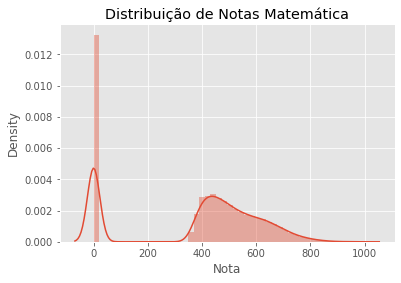

In [18]:
# Verificar a distribuição das notas
#MATEMÁTICA
notaMAT = 'NU_NOTA_MT'
print(df_train[notaMAT].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas Matemática")
sns.distplot(df_train[notaMAT], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

count    153703.000000
mean        347.910725
std         222.289812
min           0.000000
25%           0.000000
50%         431.000000
75%         508.300000
99%         650.200000
max         831.600000
Name: NU_NOTA_CN, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


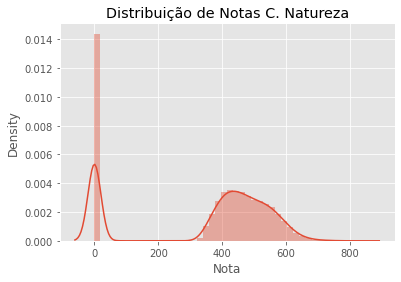

In [19]:
#CIÊNCIAS DA NATUREZA
notaCN = 'NU_NOTA_CN'
print(df_train[notaCN].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas C. Natureza")
sns.distplot(df_train[notaCN], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

count    153703.000000
mean        390.514518
std         225.502426
min           0.000000
25%         356.500000
50%         474.800000
75%         549.800000
99%         675.600000
max         808.300000
Name: NU_NOTA_CH, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


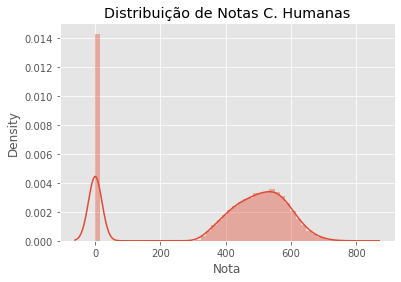

In [20]:
#CIÊNCIAS HUMANAS
notaCH = 'NU_NOTA_CH'
print(df_train[notaCH].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas C. Humanas")
sns.distplot(df_train[notaCH], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

count    153703.000000
mean        400.916098
std         226.281101
min           0.000000
25%         381.600000
50%         502.900000
75%         553.000000
99%         640.000000
max         745.700000
Name: NU_NOTA_LC, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


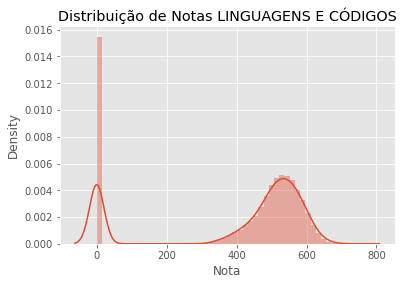

In [21]:
#LINGUAGENS E CÓDIGOS
notaLC = 'NU_NOTA_LC'
print(df_train[notaLC].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas LINGUAGENS E CÓDIGOS")
sns.distplot(df_train[notaLC], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

count    153703.000000
mean        439.348744
std         291.858943
min           0.000000
25%           0.000000
50%         540.000000
75%         640.000000
99%         940.000000
max        1000.000000
Name: NU_NOTA_REDACAO, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


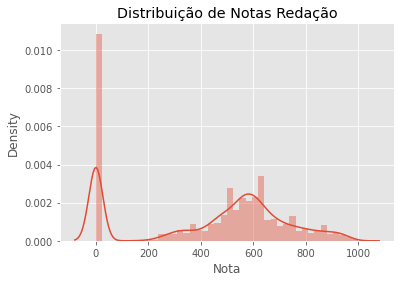

In [22]:
#REDAÇÃO
notaRED = 'NU_NOTA_REDACAO'
print(df_train[notaRED].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas Redação")
sns.distplot(df_train[notaRED], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

In [ ]:
#Depois dessa análise, pode ser mais interessante excluir os dados com nota zerada.

In [31]:
#Selecionar, pela função pandas .query, aqueles alunos que não tiraram '0' em nenhuma matéria e que estiveram presente em todos os dias de prova - resolvi deixar os 'treineiros'
df_train2 = df_train.query('TP_PRESENCA_CN==1 and TP_PRESENCA_CH==1 and TP_PRESENCA_LC==1 and TP_PRESENCA_MT==1 and TP_STATUS_REDACAO==1 and TP_ST_CONCLUSAO==2 and NU_NOTA_CN >0 and NU_NOTA_CH >0 and NU_NOTA_LC >0 and NU_NOTA_MT >0 and NU_NOTA_REDACAO >0')

count    35635.000000
mean       527.342116
std        108.728908
min        359.000000
25%        439.400000
50%        506.000000
75%        602.700000
99%        809.032000
max        985.500000
Name: NU_NOTA_MT, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


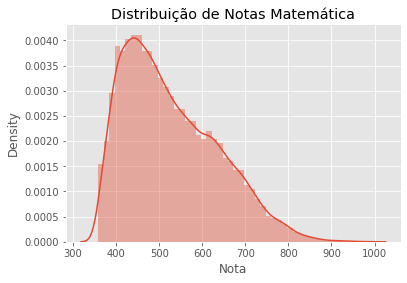

In [32]:
#MATEMÁTICA
notaMAT = 'NU_NOTA_MT'
print(df_train2[notaMAT].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas Matemática")
sns.distplot(df_train2[notaMAT], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

count    35635.000000
mean       476.664445
std         75.652548
min        327.900000
25%        416.300000
50%        469.100000
75%        533.200000
99%        653.500000
max        831.600000
Name: NU_NOTA_CN, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


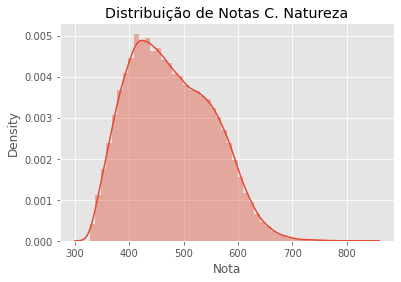

In [33]:
#CIÊNCIAS DA NATUREZA
notaCN = 'NU_NOTA_CN'
print(df_train2[notaCN].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas C. Natureza")
sns.distplot(df_train2[notaCN], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

count    35635.000000
mean       509.373119
std         78.784726
min        315.900000
25%        451.300000
50%        512.300000
75%        567.300000
99%        679.266000
max        808.300000
Name: NU_NOTA_CH, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


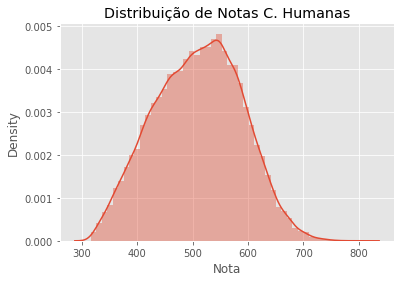

In [34]:
#CIÊNCIAS HUMANAS
notaCH = 'NU_NOTA_CH'
print(df_train2[notaCH].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas C. Humanas")
sns.distplot(df_train2[notaCH], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

count    35635.000000
mean       522.154567
std         61.926640
min        324.000000
25%        485.100000
50%        527.100000
75%        566.500000
99%        643.300000
max        742.600000
Name: NU_NOTA_LC, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


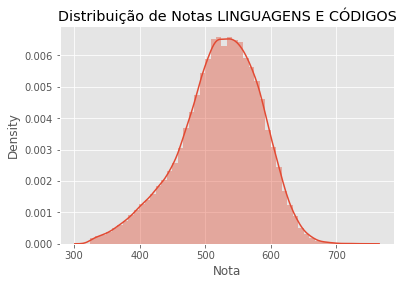

In [35]:
#LINGUAGENS E CÓDIGOS
notaLC = 'NU_NOTA_LC'
print(df_train2[notaLC].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas LINGUAGENS E CÓDIGOS")
sns.distplot(df_train2[notaLC], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

count    35635.000000
mean       604.324961
std        159.596913
min         60.000000
25%        500.000000
50%        600.000000
75%        700.000000
99%        960.000000
max       1000.000000
Name: NU_NOTA_REDACAO, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


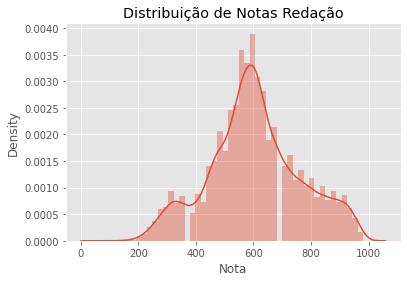

In [36]:
#REDAÇÃO
notaRED = 'NU_NOTA_REDACAO'
print(df_train2[notaRED].describe(percentiles=[.25, .5, .75, .99]))
f, ax = plt.subplots()
ax.set(title="Distribuição de Notas Redação")
sns.distplot(df_train2[notaRED], axlabel="Nota")
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)

In [39]:
#Notas obtidas
notas = df_train2[['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO']]

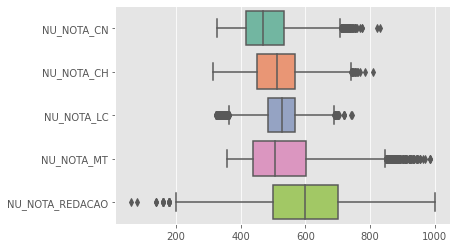

In [40]:
#Observação da Distribuição das notas
# A REDAÇÃO é a matéria com maior amplitude de nota.
notas_dist = notas.melt(id_vars=[],
                        var_name='Tipo_Nota',
                        value_name='Resultado'
                      )
ax = sns.boxplot(data=notas, orient='h', palette='Set2')

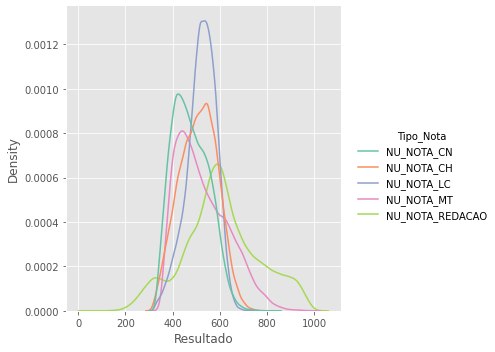

In [44]:
ax= sns.displot(data=notas_dist, x='Resultado', hue='Tipo_Nota', palette='Set2', kind='kde')

In [68]:
# Inspirada pela aula que assisti (WOMAKERS - 15/02/22), criei duas variáveis com o resultado total, ao invés das notas individuais, para poder utilizar na análise exploratória
# NOTA_OBJETIVA = SOMA DAS NOTAS, desconsiderando a nota da redação
df_train2.eval('NOTA_OBJETIVA = (NU_NOTA_CN + NU_NOTA_CH + NU_NOTA_LC + NU_NOTA_MT) / 4', inplace=True)

In [69]:
# NOTA_FINAL = SOMA DAS NOTAS, considerando a nota da redação
df_train2.eval('NOTA_FINAL = (NOTA_OBJETIVA * 4 + NU_NOTA_REDACAO) / 5', inplace=True)

In [46]:
#criando a variável features com as notas que deverão ser preditas, essas colunas estão na base df_train2
features_corr = [
    'NU_NOTA_MT',
    'NU_NOTA_CN',
    'NU_NOTA_CH',
    'NU_NOTA_LC',
    'NU_NOTA_REDACAO']

In [47]:
#verificando a soma dos valores nulos nas features
df_train2[features_corr].isnull().sum()

NU_NOTA_MT         0
NU_NOTA_CN         0
NU_NOTA_CH         0
NU_NOTA_LC         0
NU_NOTA_REDACAO    0
dtype: int64

In [48]:
#Verificando a soma dos valores não-nulos nas features - eu quis ver a proporção entre um e outra
df_train2[features_corr].notnull().sum()

NU_NOTA_MT         35635
NU_NOTA_CN         35635
NU_NOTA_CH         35635
NU_NOTA_LC         35635
NU_NOTA_REDACAO    35635
dtype: int64

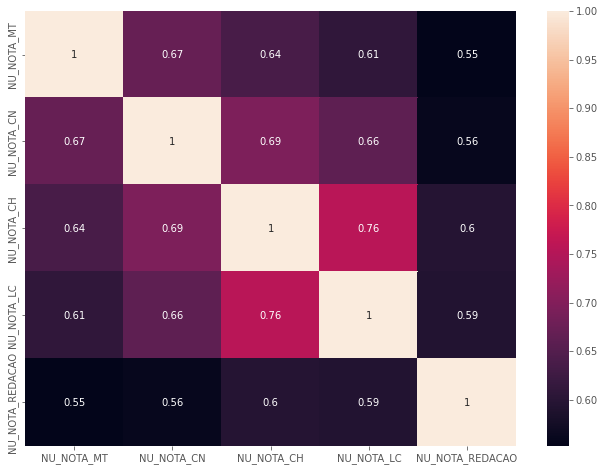

In [49]:
#ver correlações das features por heatmap
# Observa-se que as notas são positivamente correlacionadas.
corr = df_train2[features_corr].corr()
ax = plt.subplots(figsize=(11, 8))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10})

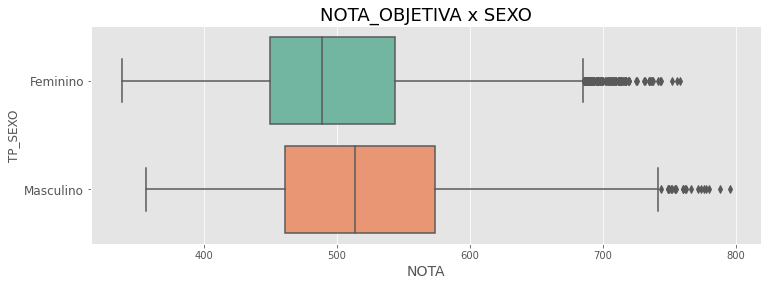

In [82]:
ax = sns.boxplot(x = df_train2['NOTA_OBJETIVA'], y=df_train['TP_SEXO'], data=notas, orient='h', palette='Set2')
ax.figure.set_size_inches(12,4)
ax.set_title('NOTA_OBJETIVA x SEXO', fontsize=18)
ax.set_xlabel('NOTA', fontsize=14)
ax.set_yticklabels(['Feminino', 'Masculino'], fontsize=12) 
ax

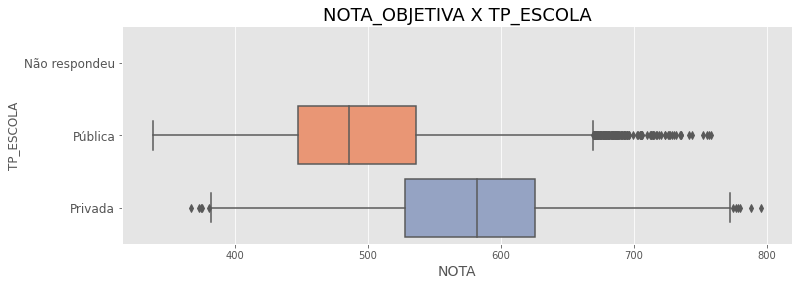

In [81]:
ax = sns.boxplot(x = df_train2['NOTA_OBJETIVA'], y=df_train['TP_ESCOLA'], data=notas, orient='h', palette='Set2')
ax.figure.set_size_inches(12,4)
ax.set_title('NOTA_OBJETIVA X TP_ESCOLA', fontsize=18)
ax.set_xlabel('NOTA', fontsize=14)
ax.set_yticklabels(['Não respondeu', 'Pública', 'Privada'], fontsize=12) 
ax

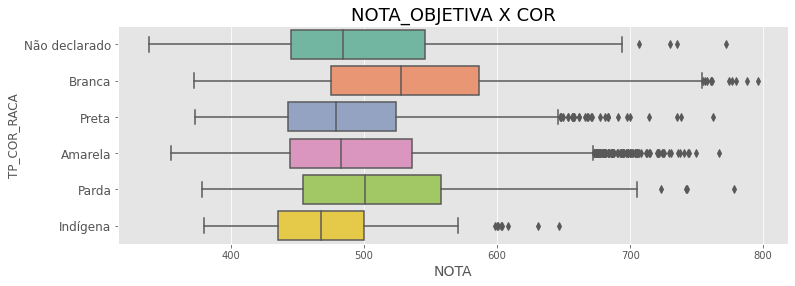

In [78]:
ax = sns.boxplot(x = df_train2['NOTA_OBJETIVA'], y=df_train['TP_COR_RACA'], data=notas, orient='h', palette='Set2')
ax.figure.set_size_inches(12,4)
ax.set_title('NOTA_OBJETIVA X COR', fontsize=18)
ax.set_xlabel('NOTA', fontsize=14)
ax.set_yticklabels(['Não declarado', 'Branca', 'Preta', 'Amarela', 'Parda', 'Indígena'], fontsize=12)  
ax

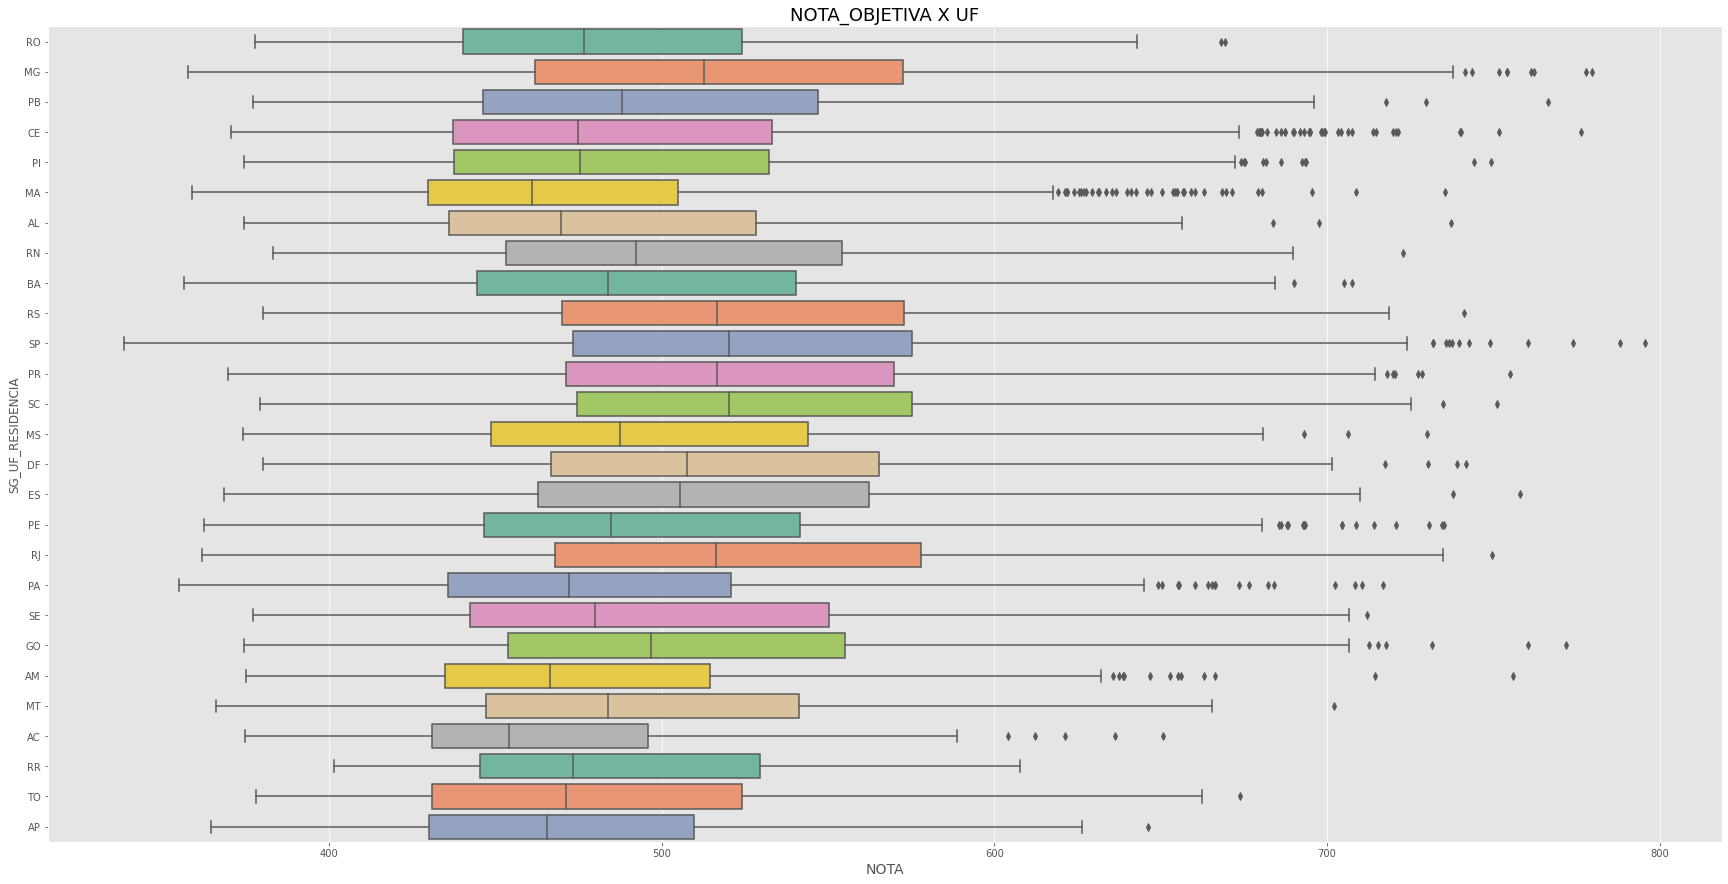

In [77]:
ax = sns.boxplot(x = df_train2['NOTA_OBJETIVA'], y=df_train['SG_UF_RESIDENCIA'], data=notas, orient='h', palette='Set2')
ax.figure.set_size_inches(30,15)
ax.set_title('NOTA_OBJETIVA X UF', fontsize=18)
ax.set_xlabel('NOTA', fontsize=14)
ax

In [83]:
df_submission = pd.read_csv('/content/sample_submission.csv', sep=',')

In [84]:
df_submission['NU_INSCRICAO']= df_test['NU_INSCRICAO']

In [89]:
#RELEMBRANDO AS FEATURES
features = [
    'NU_NOTA_MT',
    'NU_NOTA_CN',
    'NU_NOTA_CH',
    'NU_NOTA_LC',
    'NU_NOTA_REDACAO']

In [90]:
#relembrando qeu eu já havia chamado uma variável com as colunas de notas
notas = df_train2[['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO']]

In [93]:
df_test = df_test.query('TP_PRESENCA_CN==1 and TP_PRESENCA_CH==1 and TP_PRESENCA_LC==1 and TP_PRESENCA_MT==1 and TP_STATUS_REDACAO==1 and TP_ST_CONCLUSAO==2')

In [99]:
#Define coluna com nota de matemática como target
y = notas
x_train = df_train2[features]
x_test = df_train2[features]

#Aplicação de escala na base
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  
x_train = sc.fit_transform(x_train)  
x_test = sc.transform(x_test)

In [100]:
print('Média: {}'.format(x_train.mean(axis=1)))
print('Desvio padrão: {}'.format(x_train.std(axis=0)))

Média: [-0.14239312 -1.10848299 -0.01764787 ...  1.20345738  1.39282029
  0.06402873]
Desvio padrão: [1. 1. 1. 1. 1.]


In [102]:
#Criação da pipeline para crossvalidation
#n_estimators=100 (número de nós) , n_jobs=-1 ( todo o processamento possível) , warm_start=True (mantém o aprendizado e reprocessa o modelo, melhorando-o)
pipeline = make_pipeline(preprocessing.StandardScaler(), RandomForestRegressor(n_estimators=200, n_jobs=-1, warm_start=True))

In [103]:
#DEFINIÇÃO DE HIPERPARÂMETROS
# max_features : O número de features a considerar quando pesquisar pela melhor separação (testará as 3 opções e identificará a melhor para o modelo)
# max_depth :  Profundidade máxima da árvore de decisão. Se None (nenhuma), os nós serão expandidos até acabar as folhas ou até que elas contenham o mínimo valor de amostras possível.
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

In [ ]:
# Ajustar e sintonizar o modelo
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
clf.fit(x_train, y)

In [ ]:
print(clf.best_params_)

In [ ]:
pred_notas = clf.predict(x_test)
pred_notas_treino = clf.predict(x_train)